In [ ]:
pip install langchain langchain_openai pypdf azure-ai-inference azure-core chromadb streamlit

In [ ]:
import streamlit as st
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pypdf import PdfReader
from azure.ai.inference import EmbeddingsClient
from azure.core.credentials import AzureKeyCredential
import chromadb
import os
from openai import OpenAI

In [ ]:
endpoint = "https://models.inference.ai.azure.com"
model_name = "text-embedding-3-large"
token = os.environ["GITHUB_TOKEN"]

In [ ]:
client = chromadb.Client()
collection = client.get_collection(name="pdf_embeddings") #since collection was already created, use get_collection method
embedding_client = EmbeddingsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(token)
)
openai_client = OpenAI(base_url=endpoint, api_key=token)

In [ ]:
#to upload file
st.title("RAG-based Q&A Bot")
st.write("Upload a PDF and ask questions based on its content.")

uploaded_file = st.file_uploader("Upload your PDF", type=["pdf"])

In [ ]:
if uploaded_file is not None:
    # Load PDF content
    def load_pdf_content(pdf_stream):
        reader = PdfReader(pdf_stream)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
        return text

    pdf_text = load_pdf_content(uploaded_file)

    # Chunk the text
    def chunk_text(text, chunk_size=500, chunk_overlap=50):
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size, chunk_overlap=chunk_overlap
        )
        return splitter.split_text(text)

    chunks = chunk_text(pdf_text)

    # Store embeddings in ChromaDB
    for i, chunk in enumerate(chunks):
        with st.spinner(f"Processing chunk {i + 1}/{len(chunks)}..."):
            response = embedding_client.embed(input=[chunk], model=model_name)
            if 'data' in response and response['data']:
                embedding = response['data'][0]['embedding']
                collection.add(
                    embeddings=[embedding],
                    documents=[chunk],
                    ids=[f"chunk_{i}"],
                    metadatas=[{"chunk_index": i}]
                )

    st.success("PDF processed and stored in ChromaDB!")

    # Question Answering
    question = st.text_input("Ask a question:")
    if st.button("Get Answer") and question:
        # Query ChromaDB
        def query_chromadb(question):
            query_embedding = embedding_client.embed(input=[question], model=model_name)
            if 'data' in query_embedding and query_embedding['data']:
                query_embedding = query_embedding['data'][0]['embedding']
            else:
                st.error("Failed to retrieve embedding for the question.")
                return

            results = collection.query(
                query_embeddings=[query_embedding], n_results=3
            )

            context = "\n".join([doc for doc in results["documents"][0]])

            response = openai_client.chat.completions.create(
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": question},
                    {"role": "assistant", "content": f"Context:\n{context}"},
                ],
                temperature=1.0,
                top_p=1.0,
                max_tokens=1000,
                model="gpt-4o",
            )

            return response.choices[0].message.content

        with st.spinner("Generating answer..."):
            answer = query_chromadb(question)
            if answer:
                st.write(f"**Answer:** {answer}")

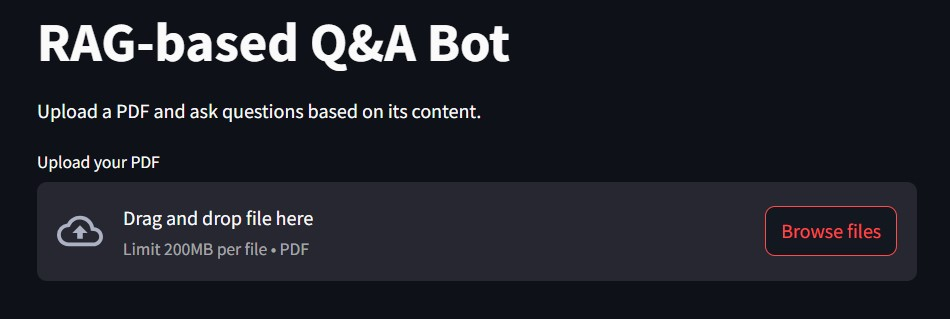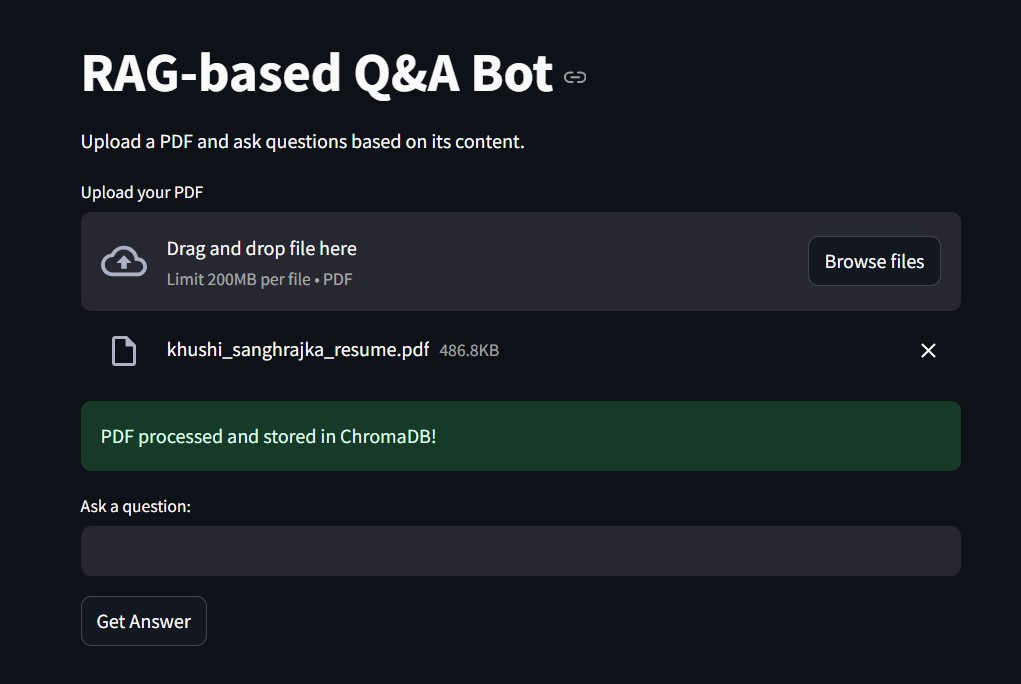